# Plot Map

## Cluster Setting
Dask is a flexible library for parallel computing in Python. 

Dask.distributed is a lightweight library for distributed computing in Python.

The Client is the primary entry point for users of dask.distributed.

In [1]:
# # this block starts clusters we will need for fast parallel? calculations
# from dask_gateway import Gateway
# from dask.distributed import Client
# gateway = Gateway()
# cluster = gateway.new_cluster()
# cluster.adapt(minimum=2, maximum=20)
# client = Client(cluster)
# cluster

In [2]:
# all sorts of packsges. there are some exceptions to deal with later
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs # Pythonic file-system for Google Cloud Storage
import xesmf as xe
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4
import os
import shelve
from scipy.interpolate import griddata

# %matplotlib inline

/srv/conda/envs/notebook/lib/python3.8/site-packages/ESMF/api/grid.py:220: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if num_peri_dims is not 0:
/srv/conda/envs/notebook/lib/python3.8/site-packages/ESMF/api/grid.py:252: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if num_peri_dims is not 0:
/srv/conda/envs/notebook/lib/python3.8/site-packages/ESMF/api/grid.py:896: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if len(staggerloc) is 1:
/srv/conda/envs/notebook/lib/python3.8/site-packages/ESMF/util/slicing.py:84: SyntaxWarning: "is" with a literal. Did you mean "=="?
  assert (len(slc) is 3)
/srv/conda/envs/notebook/lib/python3.8/site-packages/ESMF/api/mesh.py:141: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if meshname is not "":
/srv/conda/envs/notebook/lib/python3.8/site-packages/ESMF/api/mesh.py:145: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if varname is not "":


In [3]:
# this function pulls the data from the server. it is an algorithm not the calculation 
# also exceptions
def get_data(df, var, model, expe, freq):
    try:
        uri = df[(df.variable_id == var) & \
                 (df.source_id == model) & \
                 (df.experiment_id == expe) & \
                 (df.table_id == freq)].zstore.values[0]
        gcs = gcsfs.GCSFileSystem(token='anon')
        ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    except:
        ds = []
        print(model, ": no data")
    return ds    
   

Fetch the data from 15 models that have biogeochem output.



In [4]:
# regrid method: also an algorythm
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 91, 1.0)),
                     'lon': (['lon'], np.arange(0, 361, 1.0)),
                    }
                   )
ds_out

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 361)
Coordinates:
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0 360.0
Data variables:
    *empty*

In [5]:
# # version from Github
# # logic: Read a model and pull the var (Surface are with -"os" whichever is available) 

# df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')


# # skip MRi model due to time format. Updated list. sometimes it works. I am confused
# models = ['CESM2', 'CESM2-WACCM', 'GFDL-CM4', 'GFDL-ESM4', 'IPSL-CM6A-LR',  
#           'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'MIROC-ES2L', 'NorCPM1', 
#            'NorESM2-LM', 'MPI-ESM1-2-HR', 'UKESM1-0-LL', 'CNRM-ESM2-1','ACCESS-ESM1-5','MPI-ESM1-2-LR',
#             'CanESM5-CanOE','CanESM5','EC-Earth3' ]

# # varnames = ['phyc', 'chlos', 'phydiatos', 'intpp','tos']
# # var = ['tos']
# # var = 'chlmisc'
# # var = 'phyc'
# # var = 'dfeos'
# # var = 'intppdiat'
# # var = 'phydiat'
# # var = 'epc100'
# # var = 'tos'
# # var = 'spco2'
# # var = 'fgco2'
# # var = 'intpp'
# # var = 'zpico'
# # var = 'rsntds'
# # var = 'zooc'
# # var = 'no3os'
# # var='sios'
# var_names = ['phyc', 'zooc']
# expe = 'historical'
# freq = 'Omon'

# # var2 = 'phyc'
# start_time = '2003'
# end_time = '2007'
# # #seconf set for the end of 100 years
# expe2 = 'ssp585'
# start_time2 = '2081'
# end_time2 = '2100' #2099



# xrays = []
# xrays2 = []
# new_models = []

# for model in models:
#     print(model)
#     var2 = var+'os'
#     xray = get_data(df, var2, model, expe, freq)
#     if model == 'UKESM1-0-LL' or model ==  'CNRM-ESM2-1': 
#         xray = get_data(df, var, model, expe, freq) 


#     # if xray is not empty
#     if isinstance(xray, xr.Dataset):  

# #         xray2 = get_data(df, var, model, expe2, freq)
# #         if isinstance(xray2, xr.Dataset):
#             xrays.append(xray)

# #             xrays2.append(xray2)

#             new_models.append(model)

# xray_dic = {key:value for key, value in zip(new_models, xrays)}
# # xray2_dic = {key:value for key, value in zip(new_models, xrays2)}

In [6]:
# print(new_models)

For a map of average

In [7]:
# %%time

# # 
# regrids1 = []
# # regrids2 = []
# # regrids3 = []


# for model in new_models:
#     print(model)
#     vvar = var+'os' 
#     if 'latitude' in xray_dic[model].coords:    
#         xray_dic[model] = xray_dic[model].rename({'longitude': 'lon', 'latitude': 'lat'})
#     if 'nav_lat' in xray_dic[model].coords:
#         xray_dic[model] = xray_dic[model].rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
#     if model == 'UKESM1-0-LL' or model ==  'CNRM-ESM2-1': 
#         vvar = var 

#     ds = xray_dic[model].sel(time=slice(start_time, end_time))[vvar].mean(dim='time')
# #     ds_end = xray2_dic[model].sel(time=slice(start_time2, end_time2))[var].mean(dim='time')


#     if 'lev_partial' in ds.coords:
#         ds = ds.isel(lev_partial=0)
# #         ds_end = ds_end.isel(lev_partial=0)
#     if 'olevel' in ds.coords:
#         ds = ds.isel(olevel=0)
# #         ds_end = ds_end.isel(olevel=0)
#     if 'lev' in ds.coords:
#         ds = ds.isel(lev=0)
# #         ds_end = ds_end.isel(lev=0)
#     if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
#         ds=ds.where(ds!= 0)

# #     ds_diff = np.subtract(ds, ds_end)     
#     dsr = xe.Regridder(ds, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)


#     dsr._grid_in = None
#     dsr._grid_out = None
#     dsr_out = dsr(ds)
# #     dsr_out_end = dsr(ds_end)
# #     dsr_out_diff = dsr(ds_diff)

# #     dsr.clean_weight_file() # comented, coz regridder has no attribute clean_weight_file()  I guess, coz we do not reuse the weights anywah
# # checked by running dsr



#     regrids1.append(dsr_out)  # appends a model to a set
# #     regrids2.append(dsr_out_end)
# #     regrids3.append(dsr_out_diff)

# #regrid_dic = {key:value for key, value in zip(new_models, regrids1,regrids2,regrids3)}


In [8]:
# version from Github
# logic: Read a model and pull the var (Surface are with -"os" whichever is available) 

df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')


# skip MRi model due to time format. Updated list. sometimes it works. I am confused
models = ['CESM2', 'CESM2-WACCM', 'GFDL-CM4', 'GFDL-ESM4', 'IPSL-CM6A-LR',  
          'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'MIROC-ES2L', 'NorCPM1', 
           'NorESM2-LM', 'MPI-ESM1-2-HR', 'UKESM1-0-LL', 'CNRM-ESM2-1','ACCESS-ESM1-5','MPI-ESM1-2-LR',
            'CanESM5-CanOE','CanESM5','EC-Earth3' ]
# var = 'phyc'
var_names = ['phyc', 'zooc']
expe = 'historical'
freq = 'Omon'

# var2 = 'phyc'
start_time = '1991'
end_time = '2010'
# #seconf set for the end of 100 years
expe2 = 'ssp585'
start_time2 = '2081'
end_time2 = '2100' #2099



xrays = []
xrays2 = []
new_models = []

for model in models:
    print(model)
    for var in var_names:
        var2 = var+'os'
        if var == 'zooc':
            xray = get_data(df, var2, model, expe, freq)
            if model == 'UKESM1-0-LL' or model ==  'CNRM-ESM2-1': 
                xray = get_data(df, var, model, expe, freq) 

            # if xray is not empty
            if isinstance(xray, xr.Dataset):  

        #         xray2 = get_data(df, var, model, expe2, freq)
        #         if isinstance(xray2, xr.Dataset):
                    xrays.append(xray)

        #             xrays2.append(xray2)

                    new_models.append(model)
        else:
            xray2 = get_data(df, var2, model, expe, freq)
            if model == 'UKESM1-0-LL' or model ==  'CNRM-ESM2-1': 
                xray2 = get_data(df, var, model, expe, freq) 

            # if xray is not empty
            if isinstance(xray2, xr.Dataset):  

        #         xray2 = get_data(df, var, model, expe2, freq)
        #         if isinstance(xray2, xr.Dataset):
                    xrays2.append(xray2)

        #             xrays2.append(xray2)

xray_dic = {key:value for key, value in zip(new_models, xrays)}
xray2_dic = {key:value for key, value in zip(new_models, xrays2)}


# 
regrids1 = []
regrids2 = []
# regrids3 = []


for model in new_models:
    print(model)
    for var in var_names:
        vvar = var+'os'
        if var == 'zooc':         
            if 'latitude' in xray_dic[model].coords:    
                xray_dic[model] = xray_dic[model].rename({'longitude': 'lon', 'latitude': 'lat'})
            if 'nav_lat' in xray_dic[model].coords:
                xray_dic[model] = xray_dic[model].rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
            if model == 'UKESM1-0-LL' or model ==  'CNRM-ESM2-1': 
                vvar = var 

            ds = xray_dic[model].sel(time=slice(start_time, end_time))[vvar].mean(dim='time')
        #     ds_end = xray2_dic[model].sel(time=slice(start_time2, end_time2))[var].mean(dim='time')


            if 'lev_partial' in ds.coords:
                ds = ds.isel(lev_partial=0)
        #         ds_end = ds_end.isel(lev_partial=0)
            if 'olevel' in ds.coords:
                ds = ds.isel(olevel=0)
        #         ds_end = ds_end.isel(olevel=0)
            if 'lev' in ds.coords:
                ds = ds.isel(lev=0)
        #         ds_end = ds_end.isel(lev=0)
            if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
                ds=ds.where(ds!= 0)
#             if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
#                 if var == 'phyc' or var == 'chl' or var == 'phydiat' or var == 'zooc' or var == 'no3' or var == 'si' or var == 'dfe':
#                     ds = ds.where(ds>=0)
        #     ds_diff = np.subtract(ds, ds_end) 
            
            dsr = xe.Regridder(ds, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)


            dsr._grid_in = None
            dsr._grid_out = None
            dsr_out = dsr(ds)

        #     dsr_out_end = dsr(ds_end)
        #     dsr_out_diff = dsr(ds_diff)

        #     dsr.clean_weight_file() # comented, coz regridder has no attribute clean_weight_file()  I guess, coz we do not reuse the weights anywah
        # checked by running dsr



            regrids1.append(dsr_out)  # appends a model to a set
        #     regrids2.append(dsr_out_end)
        #     regrids3.append(dsr_out_diff)

        #regrid_dic = {key:value for key, value in zip(new_models, regrids1,regrids2,regrids3)}
        else:
            if 'latitude' in xray2_dic[model].coords:    
                xray2_dic[model] = xray2_dic[model].rename({'longitude': 'lon', 'latitude': 'lat'})
            if 'nav_lat' in xray2_dic[model].coords:
                xray2_dic[model] = xray2_dic[model].rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
            if model == 'UKESM1-0-LL' or model ==  'CNRM-ESM2-1': 
                vvar = var 

            ds = xray2_dic[model].sel(time=slice(start_time, end_time))[vvar].mean(dim='time')
        #     ds_end = xray2_dic[model].sel(time=slice(start_time2, end_time2))[var].mean(dim='time')


            if 'lev_partial' in ds.coords:
                ds = ds.isel(lev_partial=0)
        #         ds_end = ds_end.isel(lev_partial=0)
            if 'olevel' in ds.coords:
                ds = ds.isel(olevel=0)
        #         ds_end = ds_end.isel(olevel=0)
            if 'lev' in ds.coords:
                ds = ds.isel(lev=0)
        #         ds_end = ds_end.isel(lev=0)
            if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
                ds=ds.where(ds!= 0)

        #     ds_diff = np.subtract(ds, ds_end)     
            dsr = xe.Regridder(ds, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)


            dsr._grid_in = None
            dsr._grid_out = None
            dsr_out = dsr(ds)
        #     dsr_out_end = dsr(ds_end)
        #     dsr_out_diff = dsr(ds_diff)

        #     dsr.clean_weight_file() # comented, coz regridder has no attribute clean_weight_file()  I guess, coz we do not reuse the weights anywah
        # checked by running dsr



            regrids2.append(dsr_out)  # appends a model to a set
        #     regrids2.append(dsr_out_end)
        #     regrids3.append(dsr_out_diff)

        #regrid_dic = {key:value for key, value in zip(new_models, regrids1,regrids2,regrids3)}

CESM2
CESM2-WACCM
GFDL-CM4
GFDL-CM4 : no data
GFDL-CM4 : no data
GFDL-ESM4
IPSL-CM6A-LR
GISS-E2-1-G
GISS-E2-1-G-CC
MIROC-ES2L
NorCPM1
NorCPM1 : no data
NorCPM1 : no data
NorESM2-LM
NorESM2-LM : no data
MPI-ESM1-2-HR
MPI-ESM1-2-HR : no data
UKESM1-0-LL
UKESM1-0-LL : no data
CNRM-ESM2-1
CNRM-ESM2-1 : no data
ACCESS-ESM1-5
ACCESS-ESM1-5 : no data
MPI-ESM1-2-LR
MPI-ESM1-2-LR : no data
CanESM5-CanOE
CanESM5
EC-Earth3
EC-Earth3 : no data
EC-Earth3 : no data
CESM2


/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'lat_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'lon_bnds'} not foun

CESM2-WACCM


/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'lat_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given i

GFDL-ESM4


/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'lat_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given i

IPSL-CM6A-LR


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'bounds_nav_lon'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'bounds_nav_lat'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise compariso

GISS-E2-1-G


/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'lat_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given i

GISS-E2-1-G-CC


/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'lat_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given i

MIROC-ES2L


/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'x_bnds', 'vertices_longitude', 'y_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'x_bnds', 'vertices_latitude', 'y_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/fronten

NorESM2-LM


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'vertices_longitude'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'vertices_latitude'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise co

UKESM1-0-LL


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'vertices_longitude'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'vertices_latitude'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise co

CNRM-ESM2-1


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'bounds_lon'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'bounds_lat'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed

CanESM5-CanOE


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'vertices_longitude'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'vertices_latitude'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise co

CanESM5


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'vertices_longitude'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'vertices_latitude'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise co

In [9]:
# df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
# models = ['CESM2', 'CESM2-WACCM', 'GFDL-CM4', 'GFDL-ESM4', 'IPSL-CM6A-LR',  
#           'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'MIROC-ES2L', 'NorCPM1', 
#            'NorESM2-LM', 'MPI-ESM1-2-HR', 'UKESM1-0-LL', 'CNRM-ESM2-1','ACCESS-ESM1-5','MPI-ESM1-2-LR',
#             'CanESM5-CanOE','CanESM5','EC-Earth3' ]
# var_names = ['phyc', 'zooc']

# expe = 'historical'
# freq = 'Omon'
# start_year = '1995'
# end_year = '2014'
 
# xxray_in = []

# for model in models:
#     print(model)
#     for var in var_names:
#         vvar = var + 'os'
#         xray = get_data(df, vvar, model, expe, freq)
#         if isinstance(xray, xr.Dataset):
#             xxray_in = xray
            
#         else:
#             vvar = var    
#             xray = get_data(df, vvar, model, expe, freq)
#             xxray_in= xray
            
#         if model == 'MPI-ESM1-2-HR' and (var == 'zooc' or var == 'si'):
#             print('wont work')
#         else:
#             if isinstance(xxray_in, xr.Dataset):
#                     ds = xxray_in.sel(time=slice(start_year, end_year))[vvar]

#                     if 'latitude' in ds.coords:
#                         ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})
#                     if 'nav_lat' in ds.coords:
#                         ds = ds.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})

#                     if 'lev_partial' in ds.coords:
#                         ds = ds.isel(lev_partial=0)
#                     if 'olevel' in ds.coords:
#                         ds = ds.isel(olevel=0)
#                     if 'lev' in ds.coords:
#                         ds = ds.isel(lev=0)

#                     if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
#                         if var == 'phyc' or var == 'chl' or var == 'phydiat' or var == 'zooc' or var == 'no3' or var == 'si' or var == 'dfe':
#                             ds = ds.where(ds>=0)

#                     dsr = xe.Regridder(ds, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
#                     dsr._grid_in = None
#                     dsr._grid_out = None
#                     dsr_out0 = dsr(ds)
#                     dsr_out = xr.Dataset({var:dsr_out0})

In [10]:
# checks if the value in the ds is realistic
# a = ds.values
# np.nanmax(a)

In [11]:
# checks if dsr has the right size
# dsr

In [12]:
# shows what data is in regrids1 after regridding
# print(regrids1)

## Regridding

Behzad's code for regridding:

nearest from scipy.interpolate.datagrid
https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html

Here we use xesmf
https://xesmf.readthedocs.io/en/latest/notebooks/Compare_algorithms.html


    regredding

In [13]:
# aranges the model data in to a dictionary
regrid_dic1 = {key:value for key, value in zip(new_models, regrids1)} # start of the priod
# regrid_dic_max = {key:value for key, value in zip(new_models, regrids1_max)} # start of the priod
# regrid_dic_min = {key:value for key, value in zip(new_models, regrids1_min)} # start of the priod
regrid_dic2 = {key:value for key, value in zip(new_models, regrids2)} # end of the priod
# regrid_dic3 = {key:value for key, value in zip(new_models, regrids3)} # difference for the priod

In [14]:
# enables libraries for plotting
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# import cartopy.crs as ccrs


CESM2


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CESM2-WACCM


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


GFDL-ESM4


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


IPSL-CM6A-LR


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


GISS-E2-1-G
GISS-E2-1-G-CC
MIROC-ES2L


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


NorESM2-LM


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


UKESM1-0-LL


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CNRM-ESM2-1


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CanESM5-CanOE


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CanESM5


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/CMIP6-Codes/Codes_for_June/phyc_2003_2007_Mean.png'

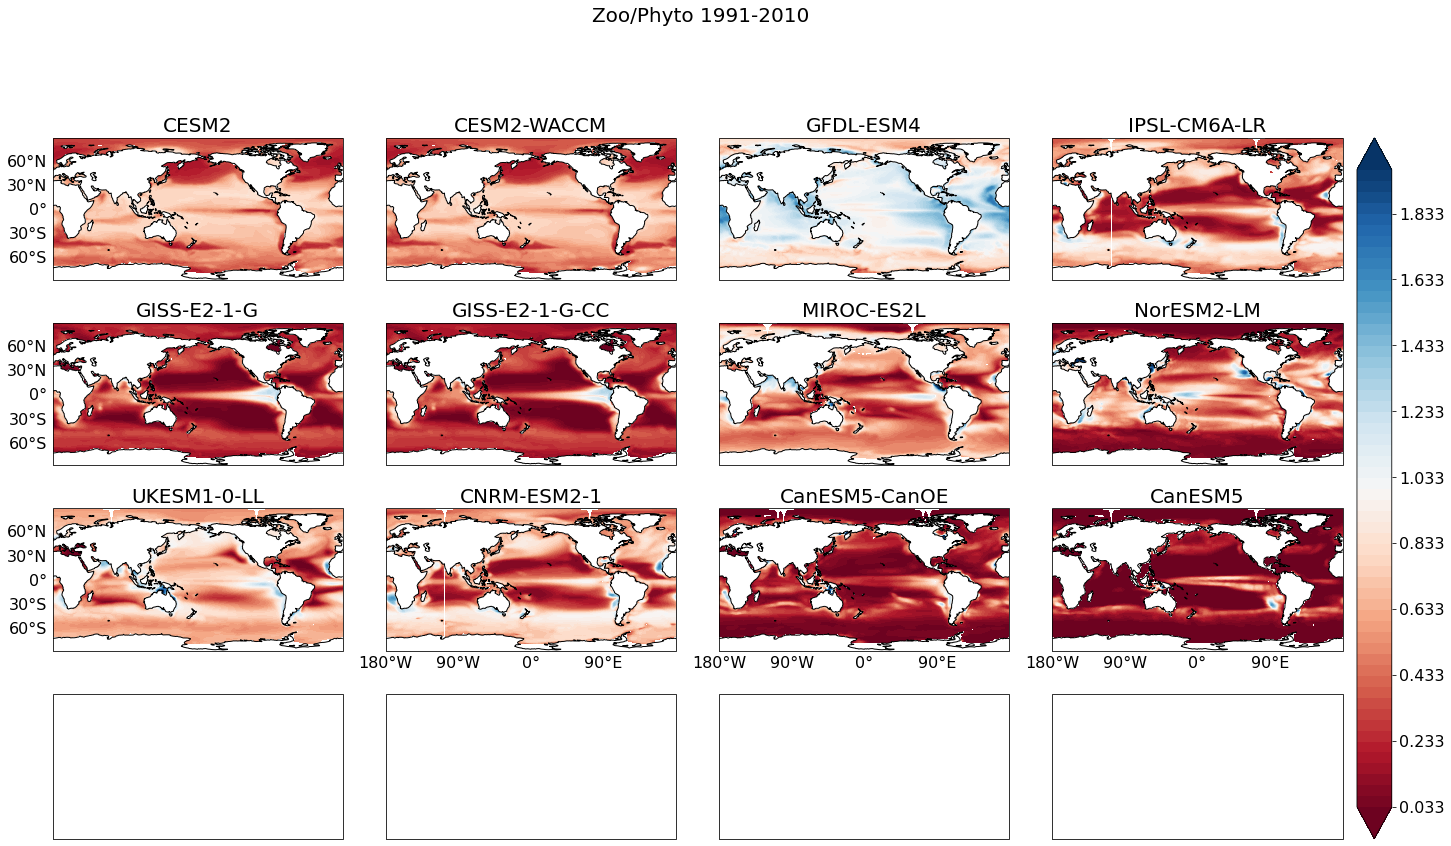

In [15]:
%%time



fig = plt.figure(figsize=(24, 14))

n_c = 4
n_r = 4
n_t=len(new_models)


projection = ccrs.PlateCarree(central_longitude=180)
axes_class = (GeoAxes,dict(map_projection=projection))
axgr = AxesGrid(fig, 111, axes_class=axes_class, nrows_ncols=(n_r, n_c),
                    axes_pad=0.6,
                    cbar_location='right',
                    cbar_mode='single',
                    cbar_pad=0.2,
                    cbar_size='3%',
                    share_all = False,
                    label_mode='')  # note the empty label_mode

#projection = ccrs.PlateCarree(central_longitude=180)
# levels = np.linspace(-0.001, 0.005, 0.02)
# levels = np.logspace(-0.001, 0.006, 0.02)
# plot_ranges 
# vmin = -0.003
# vmax = 0.003

vmin = 0
vmax = 2
n=60
levels = np.linspace(vmin, vmax, n+1)


# levels = np.logspace(vmin, vmax, n+1,base=10.0)
# levels = np.logspace(vmin, vmax, n+1) # for differences

# color map: rainbow
# cmap = mpl.cm.jet

#color map: red and blue (shows values above and below 1 more clearly)
cmap= mpl.cm.RdBu

i = 0
A = 2  # A=2 - use data "as is", A
for model in new_models:
    print(model)   
#     if isinstance(xray2_dic[model], list):  #saved this line to not forget it had to be there in other cases
    if A == 3:
        continue # here there might be some condition, for example a scale factor for units conversion
    else:
#         s = regrid_dic_max[model]*12 ## Whatch out for units. mmolC -> mgC = 12; 
        s = regrid_dic1[model]/regrid_dic2[model]   # Change value here * 12 to get miligrams/m3 from mol/m3.             
        ax = list(axgr)[i]
        i = i + 1
#        # Change Value here for levels or var or transform
        p = ax.contourf(regrid_dic1[model].lon, regrid_dic1[model].lat, s,levels=levels, cmap = cmap, transform=ccrs.PlateCarree(), extend='both')   # Change Value here
        ax.coastlines()
        ax.set_title(str(model),fontsize= 20)
    #https://stackoverflow.com/questions/49956355/adding-gridlines-using-cartopy
        gl = ax.gridlines(crs=projection, alpha=0, draw_labels=True)
#         gl.xlabels_top = False
        gl.top_labels = False
        gl.xlocator = mticker.FixedLocator([ 90, 0, -90, -180])
        gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        
        if i-1 == (n_c*(n_r-1)): # Adds longitude ranges only to the last subplots that appear at the bottom of plot
#             gl.ylabels_left = True
            gl.left_labels = True
            gl.right_labels=False
            gl.ylabel_style = {'size': 16} # labels = [left,right,top,bottom] # Longitudes
            gl.xlines = True
            gl.xlabel_style = {'size': 16}
        elif i-1==0 or i-1==n_c or i-1==n_c*2 or i-1==n_c*3 or i-1==n_c*4 or i-1==n_c*5 or i-1==n_c*6 or i-1==n_c*7 or i-1==n_c*8:
            gl.left_labels = True
            gl.right_labels=False
            gl.ylabel_style = {'size': 16} #
            gl.bottom_labels = False
        elif i-1 >= n_t-n_c and i-1 != (n_c*(n_r-1)): # Adds longitude ranges only to the last subplots that appear at the bottom of plot
            gl.left_labels = False
            gl.right_labels=False
            gl.xlines = False
            gl.xlabel_style = {'size': 16}
        else:
            gl.left_labels = False
            gl.right_labels=False
            gl.ylabel_style = {'size': 16} #
            gl.bottom_labels = False
            gl.xlines = False
            if i>n_t:
                plt.close(i)
#        
# plt.suptitle('Average 1995 - 2014, Mole Concentration of Biomass of phytoplankton [mol m-3]', fontsize=20)  # Change Value here
plt.suptitle('Zoo/Phyto 1991-2010', fontsize=20)
# cb = axgr.cbar_axes[0].colorbar(p)


cb = mpl.colorbar.ColorbarBase(axgr.cbar_axes[0], cmap = cmap, boundaries = levels, extend='both')
# cb = mpl.colorbar.ColorbarBase(axgr.cbar_axes[0], cmap = cmap,  extend='both')
cb.ax.tick_params(labelsize=16)


# plt.savefig('/home/jovyan/CMIP6-Codes/AGU_fall_pics/phyc_2003_2007.tiff', dpi=600,format='tiff')   # Change Value here
plt.savefig('/home/jovyan/CMIP6-Codes/Codes_for_June/phyc_2003_2007_Mean.png', dpi=600,format='png')   # Change Value here
# model order


FOR SEASONALITY

max-min
amin The minimum value of an array along a given axis, propagating any NaNs.

nanmax The maximum value of an array along a given axis, ignoring any NaNs.

maximum Element-wise maximum of two arrays, propagating any NaNs.

fmax Element-wise maximum of two arrays, ignoring any NaNs.

argmax Return the indices of the maximum values.

In [16]:
%%time

#too few models

regrids1 = []
regrids2 = []


for model in new_models:
    print(model)
    vvar = var+'os' 
    if model == 'UKESM1-0-LL' or model ==  'CNRM-ESM2-1': 
        vvar = var 
    if 'latitude' in xray_dic[model].coords:    
            xray_dic[model] = xray_dic[model].rename({'longitude': 'lon', 'latitude': 'lat'})
    if 'nav_lat' in xray_dic[model].coords:
            xray_dic[model] = xray_dic[model].rename({'nav_lon': 'lon', 'nav_lat': 'lat'})

    
    ds = xray_dic[model].sel(time=slice(start_time, end_time))[vvar].mean(dim='time')
    ds_max = xray_dic[model].sel(time=slice(start_time, end_time))[vvar].max(dim='time')
    ds_min = xray_dic[model].sel(time=slice(start_time, end_time))[vvar].min(dim='time')
    ds_seas = np.subtract(ds_max, ds_min)
#     vvar = var1+'os'
#     if model == 'UKESM1-0-LL' or model ==  'CNRM-ESM2-1': 
#         vvar = var1  
#     if 'latitude' in xray_dic[model].coords:    
#             xray2_dic[model] = xray_dic[model].rename({'longitude': 'lon', 'latitude': 'lat'})
#     if 'nav_lat' in xray_dic[model].coords:
#             xray2_dic[model] = xray_dic[model].rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
  
#     ds_diat = xray2_dic[model].sel(time=slice(start_time, end_time))[vvar].mean(dim='time')
#     ds_diat_max = xray2_dic[model].sel(time=slice(start_time, end_time))[vvar].max(dim='time', skipna=True)
    
    if 'lev_partial' in ds.coords:
        ds_seas = ds_seas.isel(lev_partial=0)
        ds = ds.isel(lev_partial=0)
#         ds_diat = ds_end.isel(lev_partial=0)
    if 'olevel' in ds.coords:
        ds_seas = ds_seas.isel(olevel=0)
        ds = ds.isel(olevel=0)
#         ds_diat = ds_end.isel(olevel=0)
    if 'lev' in ds.coords:
        ds_seas = ds_seas.isel(lev=0)
        ds = ds.isel(lev=0)
#         ds_diat = ds_end.isel(lev=0)

    
    
    
#     ds_diff = np.divide(ds_diat, ds)   # % micro (micro + nano)
#     ds_diff = np.subtract(ds, ds_diat)   # small
#     ds_max = np.nanmax(ds, axis=1 )   # max phytoC
#     dsr = xe.Regridder(ds, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
    dsr = xe.Regridder(ds_seas, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
#     dsrs = xe.Regridder(ds, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
        
     
    
    dsr._grid_in = None
    dsr._grid_out = None
    dsr_out = dsr(ds_seas)
    
#     dsrs._grid_in = None
#     dsrs._grid_out = None
#     dsrs_out = dsrs(ds)
     
    regrids1.append(dsr_out)
#     regrids2.append(dsrs_out)



CESM2


/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'lat_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'lon_bnds'} not foun

CESM2-WACCM


/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'lat_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


GFDL-ESM4


/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'bounds_nav_lon'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'bounds_nav_lat'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


IPSL-CM6A-LR


/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'lat_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


GISS-E2-1-G


/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'lat_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


GISS-E2-1-G-CC


/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'x_bnds', 'vertices_longitude', 'y_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'x_bnds', 'vertices_latitude', 'y_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


MIROC-ES2L


/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'vertices_longitude'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'vertices_latitude'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


NorESM2-LM


/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'vertices_longitude'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'vertices_latitude'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


UKESM1-0-LL


/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'bounds_lon'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'bounds_lat'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


CNRM-ESM2-1


/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'vertices_longitude'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'vertices_latitude'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


CanESM5-CanOE


/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'vertices_longitude'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'vertices_latitude'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


CanESM5
CPU times: user 1min 15s, sys: 7.75 s, total: 1min 23s
Wall time: 1min 23s


/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


In [17]:
a = ds_seas.values

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


In [18]:
np.nanmax(a)

0.009108279

In [19]:
# regrid_dic1 = {key:value for key, value in zip(new_models, regrids1)} # start of the priod
regrid_dic2 = {key:value for key, value in zip(new_models, regrids2)} # 

In [20]:
# print(regrid_dic1['CESM2'])
print(regrid_dic2['CESM2']) 

KeyError: 'CESM2'

In [ ]:
regrid_dic2['UKESM1-0-LL']
# print('next')
# Nn = regrid_dic2['CESM2']
# # print(Mm)
# Nn

In [ ]:

from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# import cartopy.crs as ccrs


In [ ]:
%%time  
# ratio of the diat/phyc


fig = plt.figure(figsize=(24, 14))

# from mpl_toolkits.axes_grid1 import AxesGrid
# from cartopy.mpl.geoaxes import GeoAxes
# import matplotlib.ticker as mticker
# from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
# from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# import cartopy.crs as ccrs

n_c = 4
n_r = 3
n_t=len(new_models)


projection = ccrs.PlateCarree(central_longitude=180)
axes_class = (GeoAxes,dict(map_projection=projection))
axgr = AxesGrid(fig, 111, axes_class=axes_class, nrows_ncols=(3, 4),
                    axes_pad=0.6,
                    cbar_location='right',
                    cbar_mode='single',
                    cbar_pad=0.2,
                    cbar_size='3%',
                    share_all = False,
                    label_mode='')  # note the empty label_mode

#projection = ccrs.PlateCarree(central_longitude=180)
# levels = np.linspace(-0.001, 0.005, 0.02)
# levels = np.logspace(-0.001, 0.006, 0.02)
# plot_ranges 
# vmin = -0.003
# vmax = 0.003

vmin = 0
vmax = 100
n=60
levels = np.linspace(vmin, vmax, n+1)


# levels = np.logspace(vmin, vmax, n+1,base=10.0)
# levels = np.logspace(vmin, vmax, n+1) # for differences
cmap = mpl.cm.jet
i = 0
A = 2
for model in new_models:
    print(model)   
#     if isinstance(xray2_dic[model], list):  #saved this line to not forget it had to be there in other cases
    if A == 3:
        continue
    else:
        s = regrid_dic1[model]*12000    # Change value here * 12 to get grams/m3 from mol/m3. is it millimol? Should it be multiplied by 1000?
#         s = regrid_dic3[model]*100    # for percents
        ax = list(axgr)[i]
        i = i + 1
#         p = ax.contourf(regrid_dic1[model].lon, regrid_dic1[model].lat, s, levels=levels, cmap = cmap, transform=ccrs.PlateCarree(), extend='both')   # Change Value here
        p = ax.contourf(regrid_dic1[model].lon, regrid_dic1[model].lat, s,levels=levels, cmap = cmap, transform=ccrs.PlateCarree(), extend='both')   # Change Value here
        ax.coastlines()
        ax.add_feature(cfeature.LAND, zorder=1,color='w')
        ax.set_title(str(model),fontsize= 20)
    #https://stackoverflow.com/questions/49956355/adding-gridlines-using-cartopy
        gl = ax.gridlines(crs=projection, alpha=0, draw_labels=True)
#         gl.xlabels_top = False
        gl.top_labels = False
        gl.xlocator = mticker.FixedLocator([ 90, 0, -90, -180])
        gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        
        if i-1 == (n_c*(n_r-1)): # Adds longitude ranges only to the last subplots that appear at the bottom of plot
#             gl.ylabels_left = True
            gl.left_labels = True
            gl.right_labels=False
            gl.ylabel_style = {'size': 16} # labels = [left,right,top,bottom] # Longitudes
            gl.xlines = True
            gl.xlabel_style = {'size': 16}
        elif i-1==0 or i-1==n_c or i-1==n_c*2 or i-1==n_c*3 or i-1==n_c*4 or i-1==n_c*5 or i-1==n_c*6 or i-1==n_c*7 or i-1==n_c*8:
            gl.left_labels = True
            gl.right_labels=False
            gl.ylabel_style = {'size': 16} #
            gl.bottom_labels = False
        elif i-1 >= n_t-n_c and i-1 != (n_c*(n_r-1)): # Adds longitude ranges only to the last subplots that appear at the bottom of plot
            gl.left_labels = False
            gl.right_labels=False
            gl.xlines = False
            gl.xlabel_style = {'size': 16}
        else:
            gl.left_labels = False
            gl.right_labels=False
            gl.ylabel_style = {'size': 16} #
            gl.bottom_labels = False
            gl.xlines = False
            if i>n_t:
                plt.close(i)
#        
# plt.suptitle('Average 1995 - 2014, Mole Concentration of Biomass of phytoplankton [mol m-3]', fontsize=20)  # Change Value here
# plt.suptitle(' Small phytoC for 2003-2007, Concentration of Biomass of phytoplankton [mgC m-3]', fontsize=20)
plt.suptitle(' Max-min phytoC for 2003-2007, Concentration of Biomass of phytoplankton [mgC m-3]', fontsize=20)
# cb = axgr.cbar_axes[0].colorbar(p)

cb = mpl.colorbar.ColorbarBase(axgr.cbar_axes[0], cmap = cmap, boundaries = levels, extend='both')
cb.ax.tick_params(labelsize=16)


# plt.savefig('/home/jovyan/CMIP6-Codes/AGU_fall_pics/phyc_2003_2007.tiff', dpi=600,format='tiff')   # Change Value here
# plt.savefig('/home/jovyan/CMIP6-Codes/AGU_fall_pics/small_phyC_2003_2007.png', dpi=600,format='png')   # Change Value here
plt.savefig('/home/jovyan/CMIP6-Codes/AGU_fall_pics/MaxMin_phyC_2003_2007_1.png', dpi=600,format='png')   # Change Value here
# model order

In [ ]:
## PhytoC+ZooC = POC

In [ ]:
ds_time = xr.DataArray(newtime, dims=test.dims)

In [ ]:
test.idxmax(dim = 'time', skipna = True).load()

In [ ]:
np.nanargmax(test, axis =0)

In [ ]:
test =  xray_dic[model].sel(time=slice(start_time, end_time))[vvar]

In [ ]:
test

In [ ]:
newtime = np.tile(test.time.values[:, np.newaxis, np.newaxis], (1, test.shape[1], test.shape[2]))

In [ ]:
newtime[a]

In [ ]:
a = xray_dic[model].sel(time=slice(start_time, end_time))[vvar].max(dim='time')
# xray_dic[model][vvar].where(xray_dic[model][vvar]==a)

In [ ]:
func_findtime_xr(xray_dic[model][vvar])

In [ ]:
def func_findtime(data, time):
    a = np.argmax(data)
    maxtime = time[a]
    return maxtime

In [ ]:
def func_findtime_xr(ds):
    maxtime = xr.apply_ufunc(func_findtime,
                             ds,
                             ds.time,
                             input_core_dims=[['time'],[]]
                            )
    return maxtime

In [ ]:
%%time

#too few models

regrids1 = []
regrids2 = []


for model in new_models:
    print(model)
    vvar = var+'os' 
    if model == 'UKESM1-0-LL' or model ==  'CNRM-ESM2-1': 
        vvar = var 
    if 'latitude' in xray_dic[model].coords:    
            xray_dic[model] = xray_dic[model].rename({'longitude': 'lon', 'latitude': 'lat'})
    if 'nav_lat' in xray_dic[model].coords:
            xray_dic[model] = xray_dic[model].rename({'nav_lon': 'lon', 'nav_lat': 'lat'})

    
#     ds = xray_dic[model].sel(time=slice(start_time, end_time))[vvar].mean(dim='time')
    
#     ds_max_c = xray_dic[model].sel(time=slice(start_time, end_time))[vvar].argmax(dim='time')
#     ind_max = xray_dic[model].sel(time=slice(start_time, end_time))[vvar].argmax(dim=['time'])
    ds_max_c = xray_dic[model][vvar].idxmax(dim = 'time', skipna = True)
    
#     ds_max = xray_dic[model].sel(time=slice(start_time, end_time))[vvar].max(dim='time')
    
#     ds_min = xray_dic[model].sel(time=slice(start_time, end_time))[vvar].min(dim='time')
#     ds_seas = np.subtract(ds_max, ds_min)
#     
    
    if 'lev_partial' in ds_max_c.coords:
        ds_max_c = ds_max_c.isel(lev_partial=0)
#         ds = ds.isel(lev_partial=0)
#         ds_diat = ds_end.isel(lev_partial=0)
    if 'olevel' in ds_max_c.coords:
        ds_max_c = ds_max_c.isel(olevel=0)
#         ds = ds.isel(olevel=0)
#         ds_diat = ds_end.isel(olevel=0)
    if 'lev' in ds_max_c.coords:
        ds_max_c = ds_max_c.isel(lev=0)
#         ds = ds.isel(lev=0)
#         ds_diat = ds_end.isel(lev=0)

    
    
    
#     ds_diff = np.divide(ds_diat, ds)   # % micro (micro + nano)
#     ds_diff = np.subtract(ds, ds_diat)   # small
#     ds_max = np.nanmax(ds, axis=1 )   # max phytoC
#     dsr = xe.Regridder(ds, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
    dsr = xe.Regridder(ds_max_c, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
#     dsrs = xe.Regridder(ds, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
        
     
    
    dsr._grid_in = None
    dsr._grid_out = None
    dsr_out = dsr(ds_max_c)
    
#     dsrs._grid_in = None
#     dsrs._grid_out = None
#     dsrs_out = dsrs(ds)
     
    regrids1.append(dsr_out)
#     regrids2.append(dsrs_out)



In [ ]:
a =  dsr_out[80, 60].load()
print(a)

In [ ]:
s = ds_max_c.datetime.datetime.strptime(when, '%Y-%m-%d')

In [ ]:
%%time  
# ratio of the diat/phyc


fig = plt.figure(figsize=(24, 14))

# from mpl_toolkits.axes_grid1 import AxesGrid
# from cartopy.mpl.geoaxes import GeoAxes
# import matplotlib.ticker as mticker
# from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
# from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# import cartopy.crs as ccrs

n_c = 4
n_r = 3
n_t=len(new_models)


projection = ccrs.PlateCarree(central_longitude=180)
axes_class = (GeoAxes,dict(map_projection=projection))
axgr = AxesGrid(fig, 111, axes_class=axes_class, nrows_ncols=(3, 4),
                    axes_pad=0.6,
                    cbar_location='right',
                    cbar_mode='single',
                    cbar_pad=0.2,
                    cbar_size='3%',
                    share_all = False,
                    label_mode='')  # note the empty label_mode

#projection = ccrs.PlateCarree(central_longitude=180)
# levels = np.linspace(-0.001, 0.005, 0.02)
# levels = np.logspace(-0.001, 0.006, 0.02)
# plot_ranges 
# vmin = -0.003
# vmax = 0.003

vmin = 0
vmax = 150
n=60
levels = np.linspace(vmin, vmax, n+1)


# levels = np.logspace(vmin, vmax, n+1,base=10.0)
# levels = np.logspace(vmin, vmax, n+1) # for differences
cmap = mpl.cm.jet
i = 0
A = 2
for model in new_models:
    print(model)   
#     if isinstance(xray2_dic[model], list):  #saved this line to not forget it had to be there in other cases
    if A == 3:
        continue
    else:
        s = regrid_dic1[model]   # Change value here * 12 to get grams/m3 from mol/m3. is it millimol? Should it be multiplied by 1000?
#         s = regrid_dic3[model]*100    # for percents
        ax = list(axgr)[i]
        i = i + 1
#         p = ax.contourf(regrid_dic1[model].lon, regrid_dic1[model].lat, s, levels=levels, cmap = cmap, transform=ccrs.PlateCarree(), extend='both')   # Change Value here
        p = ax.contourf(regrid_dic1[model].lon, regrid_dic1[model].lat, s, cmap = cmap, transform=ccrs.PlateCarree(), extend='both')   # Change Value here
        ax.coastlines()
        ax.set_title(str(model),fontsize= 20)
    #https://stackoverflow.com/questions/49956355/adding-gridlines-using-cartopy
        gl = ax.gridlines(crs=projection, alpha=0, draw_labels=True)
#         gl.xlabels_top = False
        gl.top_labels = False
        gl.xlocator = mticker.FixedLocator([ 90, 0, -90, -180])
        gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        
        if i-1 == (n_c*(n_r-1)): # Adds longitude ranges only to the last subplots that appear at the bottom of plot
#             gl.ylabels_left = True
            gl.left_labels = True
            gl.right_labels=False
            gl.ylabel_style = {'size': 16} # labels = [left,right,top,bottom] # Longitudes
            gl.xlines = True
            gl.xlabel_style = {'size': 16}
        elif i-1==0 or i-1==n_c or i-1==n_c*2 or i-1==n_c*3 or i-1==n_c*4 or i-1==n_c*5 or i-1==n_c*6 or i-1==n_c*7 or i-1==n_c*8:
            gl.left_labels = True
            gl.right_labels=False
            gl.ylabel_style = {'size': 16} #
            gl.bottom_labels = False
        elif i-1 >= n_t-n_c and i-1 != (n_c*(n_r-1)): # Adds longitude ranges only to the last subplots that appear at the bottom of plot
            gl.left_labels = False
            gl.right_labels=False
            gl.xlines = False
            gl.xlabel_style = {'size': 16}
        else:
            gl.left_labels = False
            gl.right_labels=False
            gl.ylabel_style = {'size': 16} #
            gl.bottom_labels = False
            gl.xlines = False
            if i>n_t:
                plt.close(i)
#        
# plt.suptitle('Average 1995 - 2014, Mole Concentration of Biomass of phytoplankton [mol m-3]', fontsize=20)  # Change Value here
# plt.suptitle(' Small phytoC for 2003-2007, Concentration of Biomass of phytoplankton [mgC m-3]', fontsize=20)
plt.suptitle('Month of Max phytoC for 2003-2007, Concentration of Biomass of phytoplankton [mgC m-3]', fontsize=20)
# cb = axgr.cbar_axes[0].colorbar(p)

cb = mpl.colorbar.ColorbarBase(axgr.cbar_axes[0], cmap = cmap, boundaries = levels, extend='both')
cb.ax.tick_params(labelsize=16)


# plt.savefig('/home/jovyan/CMIP6-Codes/AGU_fall_pics/phyc_2003_2007.tiff', dpi=600,format='tiff')   # Change Value here
# plt.savefig('/home/jovyan/CMIP6-Codes/AGU_fall_pics/small_phyC_2003_2007.png', dpi=600,format='png')   # Change Value here
plt.savefig('/home/jovyan/CMIP6-Codes/AGU_fall_pics/MaxMon_phyC_2003_2007.png', dpi=600,format='png')   # Change Value here
# model order

In [ ]:
xray_dic['CESM2']

In [ ]:
regrid_dic1 = {key:value for key, value in zip(new_models, regrids1)} # start of the priod
# regrid_dic2 = {key:value for key, value in zip(new_models, regrids2)} # start of the priod


In [ ]:
a = regrid_dic1['CESM2']

In [ ]:
# a = regrid_dic1['CESM2']
np.nanmax(a)

In [ ]:
# %%time

# regrids1 = []
# regrids2 = []
# regrids3 = []



# for model in new_models:
#     print(model)
# #model = CanESM5
#     #if isinstance(xray_dic[model], xr.Dataset):
#        # if 'latitude' in ds.coords:
#     if 'latitude' in xray_dic[model].coords:    
#             xray_dic[model] = xray_dic[model].rename({'longitude': 'lon', 'latitude': 'lat'})
#     if 'nav_lat' in xray_dic[model].coords:
#             xray_dic[model] = xray_dic[model].rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
    
#     ds = xray_dic[model].sel(time=slice(start_time, end_time))[var].mean(dim='time')
#     ds_end = xray2_dic[model].sel(time=slice(start_time2, end_time2))[var].mean(dim='time')
    
    
#     if 'lev_partial' in ds.coords:
#         ds = ds.isel(lev_partial=0)
#         ds_end = ds_end.isel(lev_partial=0)
#     if 'olevel' in ds.coords:
#         ds = ds.isel(olevel=0)
#         ds_end = ds_end.isel(olevel=0)
#     if 'lev' in ds.coords:
#         ds = ds.isel(lev=0)
#         ds_end = ds_end.isel(lev=0)

    
    
#         #ds_diff = np.subtract(ds, ds_end)  []
                  
        
# #     if model == 'GFDL-CM4' or 'IPSL-CM6A-LR' or 'CNRM-ESM2-1':
# #         print('1')
# #         ds = xray_dic[model].sel(lev=0,method='nearest')
# #         ds_end = xray2_dic[model].sel(lev=0,method='nearest')

        
#     ds_diff = np.subtract(ds, ds_end)     
#     dsr = xe.Regridder(ds, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)

        
# #     #if 'lev' in xray_dic[model]:
# #     if    model == 'GFDL-CM4':
# #         ds = xray_dic[model].sel(lev = slice(0)).sel(time=slice(start_time2, end_time2))[var].mean(dim='time')    # Trying to use only surface level for GFDL, the top layer 2.5 m
# #         ds_end = xray2_dic[model].sel(lev = slice(0)).sel(time=slice(start_time2, end_time2))[var].mean(dim='time')
# #     else:
        
# #         ds = xray_dic[model].sel(time=slice(start_time, end_time))[var].mean(dim='time')
# #         ds_end = xray2_dic[model].sel(time=slice(start_time2, end_time2))[var].mean(dim='time')
# #         #ds_diff = np.subtract(ds, ds_end)  
                  
# #     ds_diff = np.subtract(ds, ds_end)             
# #     dsr = xe.Regridder(ds, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
# #        # dsr_end = xe.Regridder(ds, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
# #        # dsr_diff =xe.Regridder(ds, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
        
#     dsr._grid_in = None
#     dsr._grid_out = None
#     dsr_out = dsr(ds)
#     dsr_out_end = dsr(ds_end)
#     dsr_out_diff = dsr(ds_diff)
#     dsr.clean_weight_file()
    
# #       saving the vars  
#     if model==1:
#         dsr_out.load()
#         dsr_out.to_netcdf("testsave_app.nc","w") 
#     else:
#         mod_name = new_models[model]
#         mod_name = dsr_out.load()
#         dsr_out.to_netcdf("testsave_app.nc","a")
      
        
#     #    dsr_out = dsr_out.fillna(-9999)
#     #    dsr_out = dsr_out.load()
#     #    outname = 'mean/' + str(model) + str(var) + 'regrid.nc'
#     #    dsr_out.to_netcdf(outname)
        
#     #else:
#      #   dsr_out = []
        
#     regrids1.append(dsr_out)
#     regrids2.append(dsr_out_end)
#     regrids3.append(dsr_out_diff)
    
# #regrid_dic = {key:value for key, value in zip(new_models, regrids1,regrids2,regrids3)}


In [ ]:
# # models = ['CESM2-WACCM','CESM2','GFDL-CM4','GFDL-ESM4','IPSL-CM6A-LR', 
# #           'MRI-ESM2-0', 'UKESM1-0-LL','CanESM5-CanOE','CanESM5', 
# #           'NorESM2-LM', 'NorESM2-MM','MPI-ESM1-2-HR','MPI-ESM1-2-LR',
# #           'CNRM-ESM2-1', 'ACCESS-ESM1-5','MIROC-ES2L']

# # skip MRi model due to time format
# models = ['CESM2-WACCM','CESM2','GFDL-CM4','GFDL-ESM4','IPSL-CM6A-LR', 
#           'UKESM1-0-LL','CanESM5-CanOE','CanESM5', 
#           'NorESM2-LM', 'NorESM2-MM','MPI-ESM1-2-HR','MPI-ESM1-2-LR',
#           'CNRM-ESM2-1', 'ACCESS-ESM1-5','MIROC-ES2L']

# # var_names=['phyc','chl','phydiat','zooc','intpp','epc100',
# #            'fgco2','spco2','dfe','no3','si','rsntds']
# var_names=['phyc','chl','phydiat',]

# expe = 'historical'
# freq = 'Omon'
# start_year = '2003'
# end_year = '2007'

# #new_models = ['GISS-E2-1-G', 'GISS-E2-1-G-CC']
# # new_vars = ['phydiat']   # new models aren't working here. 
# xxray_in = []
# # true_var = 'phydiat'
# for model in models:
#     print(model)
#     for var in var_names:
#         vvar = var + 'os'
#         xray = get_data(df, vvar, model, expe, freq) # get data with os
# #         if 'latitude' in xray.coords:
# #                  xray = xray.rename({'longitude': 'lon', 'latitude': 'lat'})
# #         if 'nav_lat' in ds.coords:
# #                  xray = xray.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
            
# #         if 'lev_partial' in xray.coords:
# #                  xray = xray.isel(lev_partial=0)
# #         if 'olevel' in ds.coords:
# #                  xray = xray.isel(olevel=0)
# #         if 'lev' in xray.coords:
# #                  xray = xray.isel(lev=0)
                
# #         if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
# #                  if var == 'phyc' or var == 'chl' or var == 'phydiat' or var == 'zooc' or var == 'no3' or var == 'si' or var == 'dfe':
# #                         xray = xray.where(ds>=0)
#         if isinstance(xray, xr.Dataset): # if ok 
#             xxray_in = xray
            
#         else:
#             vvar = var    
#             print(vvar)
#             xray = get_data(df, vvar, model, expe, freq) # data without os
#             xxray_in= xray
#         if isinstance(xxray_in, xr.Dataset): # if there is any data
#                 ds = xxray_in.sel(time=slice(start_year, end_year))[vvar]
            
#                 if 'latitude' in ds.coords:
#                     ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})
#                 if 'nav_lat' in ds.coords:
#                     ds = ds.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
            
#                 if 'lev_partial' in ds.coords:
#                     ds = ds.isel(lev_partial=0)
#                 if 'olevel' in ds.coords:
#                     ds = ds.isel(olevel=0)
#                 if 'lev' in ds.coords:
#                     ds = ds.isel(lev=0)
                
#                 if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
#                     if vvar == 'phyc' or vvar == 'chl' or vvar == 'phydiat' or vvar == 'zooc' or vvar == 'no3' or vvar == 'si' or vvar == 'dfe':
#                         ds = ds.where(ds>=0)
                        
#                 dsr = xe.Regridder(ds, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)   # regridding block
#                 dsr._grid_in = None   
#                 dsr._grid_out = None
#                 dsr_out0 = dsr(ds)
#                 dsr_out = xr.Dataset({var:dsr_out0})
#                 if dsr_out[var].shape[0]==240:
# #                     ds_np = dsr_out.sel(lat=slice(45,50)).sel(lon=slice(210,220))
#                     dsm = dsr_out[var].mean(dim='time',skipna=1)
#                     dsm.load()
               
#                 :~$ tar -czvf NA_NPssp585.tar.gz save